# **Submission for [Gen AI Intensive Course Capstone 2025Q1](https://www.kaggle.com/competitions/gen-ai-intensive-course-capstone-2025q1)**  
## _5-day Gen AI Intensive Course with Google_
@misc{gen-ai-intensive-course-capstone-2025q1,
    author = {Addison Howard and Brenda Flynn and Myles O'Neill and Nate and Polong Lin},
    title = {Gen AI Intensive Course Capstone 2025Q1},
    year = {2025},
    howpublished = {\url{https://kaggle.com/competitions/gen-ai-intensive-course-capstone-2025q1}},
    note = {Kaggle}
}

## [Link to Medium post](https://medium.com/@laurence.dewaele/document-search-with-gemini-a-capstone-project-with-google-kaggle-89c9d757a087)
![](https://miro.medium.com/v2/resize:fit:828/format:webp/1*GMP_cW55JZnccAsS_bfwTQ.jpeg)

# **Project Description**  
#### This notebook proposes a step-by-step solution for navigating a document database consisting of PDF files, in order to obtain:
#### - descriptive statistics (how many documents are in the database? what are the topics covered? ...)  
#### - answers found in the PDF documents in the document database (what are the different types of ...)  
#### - additional information through a web search.  
#### The objectives of the final solution are to be able to provide answers to these types of questions during a chat with the user.  

# **Data Sources**
#### The PDF files are taken from a series of LinkedIn posts by Analytics Vidhya, #MasteringLLMs, and #MasteringRAG.  
  
# **Notebook Architecture**  
#### At each step, the problem to be solved will be indicated 🤔, followed by 👉 how it was addressed.  

# **GenAI capabilities used**  
#### Function Calling, Agents, Grounding, Embeddings, Retrieval augmented generation (RAG), Vector search/vector store/vector database

# **❗ Make sure you have set your GOOGLE_API_KEY in the secrets!**

# **Preparing the work environment**

## Installing the necessary packages

In [1]:
# Remove conflicting packages from the Kaggle base environment.
!pip uninstall -qqy kfp jupyterlab libpysal thinc spacy fastai ydata-profiling google-cloud-bigquery google-generativeai
# Install langgraph and the packages used in this lab.
!pip install -qU 'langgraph==0.3.21' 'langchain-google-genai==2.1.2' 'langgraph-prebuilt==0.1.7'
!pip install -qU "google-genai==1.7.0" "chromadb==0.6.3"
!pip install gitpython
!pip install PyMuPDF
!pip install pandas
!pip install langchain_community
!pip install -U duckduckgo-search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.5/43.5 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.0/42.0 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 28.1 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 437.2/437.2 kB 21.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.3/47.3 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 223.6/223.6 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.7/144.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.1/611.1 kB 26.0 MB/

## Imports the necessary libraries

In [43]:
# Flag execution OK
OK = True

try:
    import json
    import os
    import time
    from datetime import datetime
    import re
    import uuid
    
    import pandas as pd
    from git import Repo
    import sqlite3
    import pymupdf
    import chromadb
    from chromadb import Documents, EmbeddingFunction, Embeddings
    
    from google import genai
    from google.genai import types
    from google.api_core import retry
    
    from kaggle_secrets import UserSecretsClient
    from pprint import pformat
    from IPython.display import display, Image, Markdown

    from typing import List, TypedDict, Annotated,Sequence
    from langchain.schema import HumanMessage
    from langchain_google_genai import ChatGoogleGenerativeAI
    from langchain_core.tools import tool
    from langchain_core.messages import BaseMessage 
    from langgraph.graph.message import add_messages
    from langchain_community.tools import DuckDuckGoSearchRun
    from langchain_core.messages import ToolMessage, SystemMessage
    from langchain_core.runnables import RunnableConfig
    from langgraph.graph import StateGraph, END

    import warnings
    warnings.filterwarnings("ignore")

except Exception as e:
    print(f"ERROR during imports: {e}")
    OK = False

## Parameters initialization

In [44]:
dict_param = {# Git repository URL
              'REPO_URL': "https://github.com/lde2015/doc_search.git",
              # Local path where to clone the repository
              'CLONE_PATH': "doc_search",
              # Sqlite database file name
              'DB_NAME': "doc_files.db",
              # Chroma vector database name
              'VECT_DB_NAME': 'doc_embd',
              # Base model
              'BASE_MODEL_ID': "gemini-2.0-flash",
              # Model for Live API
              'EXP_MODEL_ID': 'gemini-2.0-flash-exp',
              # Embedding model
              'EMBD_MODEL_ID': "models/text-embedding-004",
              # Batch size for batch processing of vector database creation
              'BATCH_SIZE': 100,
              # Max number of docs for chroma search
              "CHROMA_K": 5,
              # Similarity score threshold for search in chroma
              "CHROMA_THRESH": 1.
             }

# 🤔 How do I retrieve the document database?
### 👉 We'll use a **GitHub** repository to upload the PDF files, which we can clone locally.
---
# 🤔 How do I create a database with the file metadata?
### 👉 We'll use an **Sqlite** database with this metadata (file name, path, size, last modification date, etc.), which we can query via **SQL** queries.
---
# 🤔 How do I use the text content of PDF files?
### 👉 We'll process the text with an embedding model to transform it into a digital format, so that it can be used for document retrieval. For storage, we'll use a **ChromaDB** database.

### 🤔 The documents are in PDF format; how do I transform them into text that can be used by the embedding model?  
### 👉 We'll use the Python package **PyMuPDF** to read PDF text.   
### 🤔 There may be thousands of files in the document database. How can we load them into the **Chroma** database?   
### 👉 We'll use batch processing to process only a certain number of files at a time.

# **Initializations for the execution environment**

In [4]:
# Google API key needed
try:
    GOOGLE_API_KEY = UserSecretsClient().get_secret("GOOGLE_API_KEY")
    dict_param['GOOGLE_API_KEY'] = GOOGLE_API_KEY
    os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
    try: 
        # Parameters initialization :
        # Git repository URL
        REPO_URL = dict_param['REPO_URL']
        # Local path where to clone the repository
        CLONE_PATH = dict_param['CLONE_PATH']
        # Sqlite database file name
        DB_NAME = dict_param['DB_NAME']
        # Chroma vector database name
        VECT_DB_NAME = dict_param['VECT_DB_NAME']
        # Base model
        BASE_MODEL_ID = dict_param['BASE_MODEL_ID']
        # Model for Live API
        EXP_MODEL_ID = dict_param['EXP_MODEL_ID']
        # Embedding model
        EMBD_MODEL_ID = dict_param['EMBD_MODEL_ID']
        # Batch size for batch processing of vector database creation
        BATCH_SIZE = dict_param['BATCH_SIZE']
        # Define a helper to retry when per-minute quota is reached.
        is_retriable = lambda e: (isinstance(e, genai.errors.APIError) and e.code in {429, 503})    
    except Exception as e:
        print(f"ERROR during initialization: {e}")
        OK = False
except:
    print("GOOGLE_API_KEY needed !")
    OK = False

## Retrieving source files from the GitHub repository

In [5]:
# Clone the repository
if OK:
    try:
        Repo.clone_from(REPO_URL, CLONE_PATH)        
        print(f"Repository cloned in {CLONE_PATH}")
    except Exception as e:
        print(f"ERROR during clonage: {e}")
        OK = False

Repository cloned in doc_search


## Creating the 2 databases   
#### 💡 Since the directory can contain a large number of files, we'll define a batch process, with the batch size contained in the `BATCH_SIZE` parameter.

In [6]:
def create_bases(dict_param:dict) -> bool:
    #global df_glob
    # Custom embedding function to use with Chroma, wich implements the `EmbeddingFunction` protocol.
    class GeminiEmbeddingFunction(EmbeddingFunction):
    # Values for task type:
    #    - RETRIEVAL_DOCUMENT: Specifies the given text is a document in a search/retrieval setting.
    #    - RETRIEVAL_QUERY   : Specifies the given text is a query in a search/retrieval setting.
        def __init__(self, embedding_task='retrieval_document'):
            self.embedding_task = embedding_task
        @retry.Retry(predicate=is_retriable)
        def __call__(self, input: Documents) -> Embeddings:
            response = client.models.embed_content(
                                     model=EMBD_MODEL_ID,
                                     contents=input,
                                     config=types.EmbedContentConfig(
                                     task_type=self.embedding_task,
                                     ),
            )
            return [e.values for e in response.embeddings]
    ###
    
    # Function for retrieving metadata from a file
    def set_metadatas(entry) -> dict:
        """Extract metadata from document file.
        Args:
            The raw corresponding to the document file.
        Returns:
            Metadatas as a dict.
        """
        out_dict = {}
        try:
            # Determining file metadata
            stat_info = entry.stat()
            nom = entry.name.strip()
            timestamp = stat_info.st_mtime
            nom_court = nom.replace('.pdf', '')
            # Determining document subject
            if "of_Mastering_RAG" in nom:
                type_document = "RAG"
                nom_court = nom_court.replace('_of_Mastering_RAG','')
            else:
                type_document = "LLM"
            titre = nom_court
            try:
                rech = re.search(r"Day_\d{1,2}_(.+)", nom_court)
                if rech:
                    titre = rech.group(1).replace('_', ' ')
            except:
                pass
            out_dict = {'file_id': str(uuid.uuid4()),
                        'file_path': nom,
                        'file_size_kb': stat_info.st_size // 1024,
                        'document_subject': type_document,
                        'file_name': nom,
                        'title': titre,
                        'last_update_date': datetime.utcfromtimestamp(timestamp).isoformat()
                       }
        except Exception as e:
            print(f"ERROR in set_metadatas function : {e}")
        finally:
            return out_dict
    ###

    # Function to recover text from a pdf file
    def read_pdf_content(pdf_path:str) -> (str):
        """Read the pdf file, returning its content as text.
        Args:
            The path of the pdf file
        returns:
            A string with the text of the pdf.
        """
        content = ""
        try:
            with pymupdf.open('./'+CLONE_PATH+'/'+pdf_path) as pdf_document:
                try:
                    for page in pdf_document:
                        text = page.get_text() # get plain text encoded as UTF-8
                        doc_txt = re.sub(r' {5,}', ' <unknown> ', text.replace('\n', ' '))
                        content += doc_txt
                except Exception as e:
                    print(f"ERROR in read_pdf_content function : {e}")
        except Exception as e:
            print(f"ERROR in read_pdf_content function : {e}")
        finally:
            return content
    ###

    # Function to calculate the number of tokens in a text
    def tokens_count(client, model, doc:str) -> int:
        nb_tokens = 0
        try:
            response = client.models.count_tokens(model=model,
                                                  contents=doc)
            nb_tokens = response.total_tokens
        except Exception as e:
            print(f"ERROR in tokens_count function : {e}")
        finally:
            return nb_tokens
    ###
            
    # Batch processing function
    def batch_process(client, connexion, chromadb, model, batch_list) -> bool:
        #global df_glob
        try:
            # Creating a Pandas DataFrame from the batch to be processed
            print("   Creating a Pandas DataFrame from the batch to be processed ...")
            df = pd.DataFrame(batch_list)
            # Extracting text from PDFs & calculating the number of tokens
            print("     . extracting text from PDFs ... ...")
            df["file_content"] = df["file_path"].apply(read_pdf_content)
            print("     . calculating the number of tokens ...")
            df["tokens_number"] = df["file_content"].apply(lambda x: tokens_count(client, model, x))

            # Extracting file IDs
            list_ids = df["file_id"].tolist()
            # Extraction of texts
            list_documents = df["file_content"].tolist()
        
            # Creating embeddings in the chroma base
            print("   Creating embeddings in the chroma base ...")
            chromadb.add(documents=list_documents, ids=list_ids)
    
            # Storing batch metadata in the SQLite database
            df_glob = df.copy()
            df = df.drop('file_content', axis=1)
            print("   Storing batch metadata in the SQLite database ...")
            df.to_sql('files_details', connexion, if_exists='append', index=False)

            return True
        except Exception as e:
            print(f"ERROR in batch_process function : {e}")
            return False

    ################################################################

    print("Retrieving settings ...")
    # Git repository URL
    REPO_URL = dict_param['REPO_URL']
    # Local path where to clone the repository
    CLONE_PATH = dict_param['CLONE_PATH']
    # Sqlite database file name
    DB_NAME = dict_param['DB_NAME']
    # Chroma vector database name
    VECT_DB_NAME = dict_param['VECT_DB_NAME']
    # Base model
    BASE_MODEL_ID = dict_param['BASE_MODEL_ID']
    # Model for Live API
    EXP_MODEL_ID = dict_param['EXP_MODEL_ID']
    # Embedding model
    EMBD_MODEL_ID = dict_param['EMBD_MODEL_ID']
    # Batch size for batch processing of vector database creation
    BATCH_SIZE = dict_param['BATCH_SIZE']

    # Creating the SQLite table
    print("Creating the SQLite table ...")
    try:
        # Connect to the database (it will be created if it does not exist)
        connexion = sqlite3.connect(DB_NAME)
        cursor = connexion.cursor()

        # Create the SQLite table if it does not already exist
        cursor.execute('''
            CREATE TABLE IF NOT EXISTS files_details (
                file_id TEXT PRIMARY KEY,
                file_path TEXT,
                file_size_kb INTEGER,
                document_subject TEXT,
                file_name TEXT,
                title TEXT,
                tokens_number INTEGER,
                last_update_date DATE
            )
        ''')
    except Exception as e:
        print(f"ERROR in create sqlite database : {e}")
        return False

    # Creation of the chromadb base and the embedding function
    print("Creation of the chromadb base and the embedding function ...")
    try:
        client = genai.Client(api_key=GOOGLE_API_KEY)
        embed_fn = GeminiEmbeddingFunction()
        persist_path = "./" + VECT_DB_NAME
        if not os.path.exists(persist_path):
            os.makedirs(persist_path)
        chroma_client = chromadb.PersistentClient(path=persist_path)
        db = chroma_client.get_or_create_collection(name=VECT_DB_NAME, 
                                                    embedding_function=embed_fn)
    except Exception as e:
        print(f"ERROR in create embedding environment : {e}")
        return False

    # Directory browsing and batch processing of content
    print("Directory browsing and batch processing of content ...")
    batch_list = []
    try:        
        with os.scandir(CLONE_PATH) as it:
            for i, entry in enumerate(it, start=1):
                if entry.is_file() and entry.name.endswith(".pdf"):
                    # Determining file metadata
                    file_metadata_dict = set_metadatas(entry)
                    if not file_metadata_dict:
                        return False

                    # Added to the batch
                    batch_list.append(file_metadata_dict)

                    # If the maximum batch size is reached, batch processing is launched
                    if i % BATCH_SIZE == 0:
                        print("-> Batch processing ...")
                        result = batch_process(client, connexion, db, 
                                               BASE_MODEL_ID, batch_list)
                        if result:
                            print(i, " - Batch correctly processed")
                        else:
                            print(i, "- Batch ended with error")
                            return False
                            
                        batch_list = []
        # Traitement du dernier batch
        if batch_list:
            print("-> Batch processing ...")
            result = batch_process(client, connexion, db, BASE_MODEL_ID, batch_list)
            if result:
                print("Last Batch correctly processed")
            else:
                print("Last Batch ended with error")
                return False
    except Exception as e:
        print(f"ERROR in createbases function : {e}")
        return False

    # Closing database connections
    try:
        connexion.close()
        return True
    except Exception as e:
        print(f"ERROR in createbases function : {e}")
        return False

In [7]:
if OK:
    if create_bases(dict_param):
        print("\n * DATA LOADED.")
    else:
        print(f"\n * ERROR in createbases function : {e}")
        OK = False

Retrieving settings ...
Creating the SQLite table ...
Creation of the chromadb base and the embedding function ...
Directory browsing and batch processing of content ...
-> Batch processing ...
   Creating a Pandas DataFrame from the batch to be processed ...
     . extracting text from PDFs ... ...
     . calculating the number of tokens ...
   Creating embeddings in the chroma base ...
   Storing batch metadata in the SQLite database ...
Last Batch correctly processed

 * DATA LOADED.


# 🤔 How can we enable a system to understand the database components?  
### 👉 We'll provide it with this information.  
#### 🤨 It would be interesting to provide the model with information about the various database objects, particularly details about the meaning of each column. But in `sqlite`, it's not possible to provide comments...  
#### 💡 We'll use a dictionary to store this information.  
---  
# 🤔 How can we enable a system to interact with the database?  
### 👉 We'll provide it with functions to perform these operations.  

## Creation of a dictionary providing information on the different objects in the database

In [8]:
DICT_DB = {'files_details': 'this table contains informations about the files or documents stored in the database (name, subject, size, number of tokens, ....',
           'file_id': 'unique identifiant for each row in the table',
           'file_path': 'the relative path to the document',
           'file_size_kb': 'size of the document file in kilo bytes',
           'document_subject': 'main subject type of the document',
           'file_name': 'name of the document file',
           'title': 'a title for the document',
           'tokens_number': 'number of tokens for the text in the document',
           'last_update_date': 'last date of document file update'
           }

## Creation of the functions necessary for descriptive analyses of the documentary table

In [9]:
def list_tables() -> list[str]:
    """Retrieve the names and descriptions of all tables in the database.
    Args:
        None
    Returns:
        type: list, 1 element give table name and description.
    """
    # Include print logging statements so you can see when functions are being called.
    print(' - DB CALL: list_tables()')

    cursor = connexion.cursor()

    # Fetch the table names.
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

    tables = cursor.fetchall()
    result = [t[0] + ": " + DICT_DB[t[0]] for t in tables]
    return result



def describe_table(table_name: str) -> list[tuple[str, str, str]]:
    """Look up the table schema.
    Args:
        the name of the table whose schema we want.
    Returns:
      List of columns, where each entry is a tuple of (column, type, informations).
    """
    print(f' - DB CALL: describe_table({table_name})')

    cursor = connexion.cursor()

    cursor.execute(f"PRAGMA table_info({table_name});")

    schema = cursor.fetchall()
    # [column index, column name, column type, ...]
    return [(col[1], col[2], DICT_DB[col[1]]) for col in schema]


def execute_query(sql: str) -> list[tuple[str, ...]]:
    """Execute an SQL statement.
    Args:
        The SQL statement to execute.
    Returns:
        The execution result, as a list of tuples.
    """
    print(f' - DB CALL: execute_query({sql})')

    cursor = connexion.cursor()
    cursor.execute(sql)
    
    return cursor.fetchall()



def get_document_from_file_id(file_id: str) -> str:
    """Retrieve document name from its file id.
    Args:
        The file id.
    Returns:
        Name of the document with this file id.
    """
    print(f' - DB CALL: get_document_from_file_id({file_id})')
    
    cursor = connexion.cursor()
    
    cursor.execute("""SELECT document_subject, file_name 
                        FROM files_details 
                       WHERE file_id = ?""", (file_id,))
    result = cursor.fetchone()
    
    if result:
        document_subject, file_name = result
        return file_name+" from "+document_subject+" subject."
    else:
        return "Unkown document."

# 🤔 How to obtain statistics on the contents of the document database?  
### 👉 Using the **Function calling** feature  
#### This feature allows the chat to not only return text, but also to identify the function(s) to call to obtain the response elements, make calls to these functions, and use the results of these functions in its response.

# **Descriptive analyses of the documentary database**

## Creation of the chat interface

In [10]:
if OK:
    try:
        # Creating the necessary connections
        client = genai.Client(api_key=GOOGLE_API_KEY)
        connexion = sqlite3.connect(DB_NAME)

        # Creating a dictionary of functions allowed to be executed
        dict_functions = {
            "list_tables": list_tables,
            "describe_table": describe_table,
            "execute_query": execute_query
        }
        db_tools = [value for key, value in dict_functions.items()]
        
        instruction = """You are a helpful chatbot that can interact with an SQL database.
        You will take the users questions and turn them into SQL
        queries using the tools available. Once you have the information you need, you will
        answer the user's question using the data returned.
        Use list_tables to see what tables are present, describe_table to understand the
        schema, and execute_query to issue an SQL SELECT query."""
        
        # Start a chat
        chat = client.chats.create(
            model=BASE_MODEL_ID,
            config=types.GenerateContentConfig(
                system_instruction=instruction,
                tools=db_tools,
            ),
        )
    except Exception as e:
        print(f"ERROR during chat creation: {e}")
        OK = False

## First quantitative analyses

### **💬 What are the tables in the database? Give their names and description.**

In [51]:
if OK:
    resp = chat.send_message("What are the tables in the database? Give their names and description.")
    print(f"\n{resp.text}")

 - DB CALL: list_tables()

The table in the database is `files_details`. It contains information about the files or documents stored in the database (name, subject, size, number of tokens, ....)



### **💬 Describe the files_details table.**

In [52]:
if OK:
    resp = chat.send_message("Describe the files_details table.")
    print(f"\n{resp.text}")

 - DB CALL: describe_table(files_details)

The `files_details` table has the following columns:

*   `file_id` (TEXT): unique identifier for each row in the table
*   `file_path` (TEXT): the relative path to the document
*   `file_size_kb` (INTEGER): size of the document file in kilo bytes
*   `document_subject` (TEXT): main subject type of the document
*   `file_name` (TEXT): name of the document file
*   `title` (TEXT): a title for the document
*   `tokens_number` (INTEGER): number of tokens for the text in the document
*   `last_update_date` (DATE): last date of document file update


### **💬 How many files are in the database?**

In [53]:
if OK:
    resp = chat.send_message("How many files are in the database?")
    print(f"\n{resp.text}")

 - DB CALL: execute_query(SELECT COUNT(*) FROM files_details)

There are 60 files in the database.


### **💬 What are the subjects available?**

In [54]:
if OK:
    resp = chat.send_message("What are the subjects available?")
    print(f"\n{resp.text}")

 - DB CALL: execute_query(SELECT DISTINCT document_subject FROM files_details)

The subjects available are LLM and RAG.


### **💬 How many documents by subject?**

In [55]:
if OK:
    resp = chat.send_message("How many documents by subject?")
    print(f"\n{resp.text}")

 - DB CALL: execute_query(SELECT document_subject, COUNT(*) FROM files_details GROUP BY document_subject)

There are 38 documents with the subject LLM and 22 documents with the subject RAG.


### **💬 How many documents by subject have the text 'RAG' in their name?**

In [56]:
if OK:
    resp = chat.send_message("How many documents by subject have the text 'RAG' in their name?")
    print(f"\n{resp.text}")

 - DB CALL: execute_query(SELECT document_subject, COUNT(*) FROM files_details WHERE file_name LIKE '%RAG%' GROUP BY document_subject)

There are 2 documents with subject LLM and 22 documents with subject RAG that have the text 'RAG' in their name.


### **💬 How many documents by subject? Generate and run some code to plot this as a python seaborn chart**

In [57]:
if OK:
    resp = chat.send_message("How many documents by subject? Generate and run some code to plot this as a python seaborn chart")
    print(f"\n{resp.text}")

 - DB CALL: execute_query(SELECT document_subject, count(*) FROM files_details GROUP BY document_subject)

There are 38 LLM documents and 22 RAG documents. You can use this data to create a chart using Python's seaborn library.


## ⚡️ We would like to be able to generate graphs in exploratory analysis

# 🤔 How to generate graphs in exploratory analysis?  
### 👉 We will use **Compositional function calling**  
### This is the model's ability to compose user-provided function calls together while generating code.  
### This means that the model is able to take the available tools, generate code that uses it, and execute it all.

# **Advanced descriptive analyses (data visualization)**

## Defining the session exchange processing function

In [18]:
async def handle_response(stream, tool_impl=None):
    """Stream output and handle any tool calls during the session."""
    all_responses = []

    async for msg in stream.receive():
        all_responses.append(msg)

        if text := msg.text:
            # Output any text chunks that are streamed back.
            if len(all_responses) < 2 or not all_responses[-2].text:
                # Display a header if this is the first text chunk.
                display(Markdown('### Text'))
            print(text, end='')

        elif tool_call := msg.tool_call:
            # Handle tool-call requests.
            for fc in tool_call.function_calls:
                display(Markdown('### Tool call'))
                try:
                    func = dict_functions[fc.name]

                    # Execute the tool and collect the result to return to the model.
                    if (callable(func)) & (func in db_tools):
                        try:
                            result = func(**fc.args)
                        except Exception as e:
                            result = str(e)
                    else:
                          result = 'ko'
                except Exception as e:
                    result = str(e)

                tool_response = types.LiveClientToolResponse(
                                     function_responses=[types.FunctionResponse(
                                                         name=fc.name,
                                                         id=fc.id,
                                                         response={'result': result},)
                                                        ])

                await stream.send(input=tool_response)

        elif msg.server_content and msg.server_content.model_turn:
            # Print any messages showing code the model generated and ran.

            for part in msg.server_content.model_turn.parts:
                if code := part.executable_code:
                    display(Markdown(f'### Code\n```\n{code.code}\n```'))

                elif result := part.code_execution_result:
                    display(Markdown(f'### Result: {result.outcome}\n'
                                     f'```\n{pformat(result.output)}\n```'))

                elif img := part.inline_data:
                    display(Image(img.data))

    print()
    return all_responses

## Creation of the chat interface

In [19]:
if OK:
    try:
        model = EXP_MODEL_ID
        live_client = genai.Client(api_key=GOOGLE_API_KEY,
                                   http_options=types.HttpOptions(api_version='v1alpha'))
        connexion = sqlite3.connect(DB_NAME)
        # 
        execute_query_tool_def = types.FunctionDeclaration.from_callable(
            client=live_client, callable=execute_query)
        list_tables_tool_def = types.FunctionDeclaration.from_callable(
            client=live_client, callable=list_tables)
        describe_table_tool_def = types.FunctionDeclaration.from_callable(
            client=live_client, callable=describe_table)
        
        # Provide the model with enough information to use the tool, such as describing
        # the database so it understands which SQL syntax to use.
        sys_int = """You are a database interface. Use the `list_tables`, `describe_table`, `execute_query` tools
        to answer the users questions by looking up information in the database, running any necessary queries and responding to the user.
        Use list_tables to see what tables are present, describe_table to understand the schema, and execute_query to issue an SQL SELECT query. 
        Very important point : notice that the execute_query tool returns a list of tuples : to create a dataframe from its result, 'data' for instance,
        you must do : pd.DataFrame(data, columns=...); pd.DataFrame(data['results']) is not correct.
        If the user is requesting an action, you must also execute the actions.
        """
        
        config = {
            "response_modalities": ["TEXT"],
            "system_instruction": {"parts": [{"text": sys_int}]},
            "tools": [
                {"code_execution": {}},
                {"function_declarations": [list_tables_tool_def.to_json_dict(),
                                           describe_table_tool_def.to_json_dict(),
                                           execute_query_tool_def.to_json_dict(),                                           
                                          ]},
            ],
        }
    except Exception as e:
        print(f"ERROR during chat creation: {e}")
        OK = False

## Data exploration

### **💬 Wich tables are in the database? Give their names and descriptions.**

In [49]:
if OK:
    async with live_client.aio.live.connect(model=model, config=config) as session:
    
        message = "Wich tables are in the database? Give their names and descriptions."
        print(f"> {message}\n")
        await session.send(input=message, end_of_turn=True)
        await handle_response(session)

> Wich tables are in the database? Give their names and descriptions.



### Code
```
tables = default_api.list_tables()
print(tables)

```

### Tool call

 - DB CALL: list_tables()


### Result: Outcome.OUTCOME_OK
```
("{'result': ['files_details: this table contains informations about the files "
 'or documents stored in the database (name, subject, size, number of tokens, '
 "....']}\n")
```

### Text

The database contains one table named `files_details`. Its description is: this table contains informations about the files or documents stored in the database (name, subject, size, number of tokens, ....



### **💬 How many documents by subject? Generate and run some code to plot this as a python seaborn chart.**

> How many documents by subject? 
        Generate and run some code to plot this as a python seaborn chart.
        I suggest an horizontal bar chart, with the numbers inside each bar.
        



### Text

I need to access the database to answer this question. First, I need to see what tables are available.


### Code
```
print(default_api.list_tables())

```

### Tool call

 - DB CALL: list_tables()


### Result: Outcome.OUTCOME_OK
```
("{'result': ['files_details: this table contains informations about the files "
 'or documents stored in the database (name, subject, size, number of tokens, '
 "....']}\n")
```

### Text

Okay, the table `files_details` seems relevant. Let's examine its schema to understand the columns available.


### Code
```
print(default_api.describe_table(table_name="files_details"))

```

### Tool call

 - DB CALL: describe_table(files_details)


### Result: Outcome.OUTCOME_OK
```
("{'result': [['file_id', 'TEXT', 'unique identifiant for each row in the "
 "table'], ['file_path', 'TEXT', 'the relative path to the document'], "
 "['file_size_kb', 'INTEGER', 'size of the document file in kilo bytes'], "
 "['document_subject', 'TEXT', 'main subject type of the document'], "
 "['file_name', 'TEXT', 'name of the document file'], ['title', 'TEXT', 'a "
 "title for the document'], ['tokens_number', 'INTEGER', 'number of tokens for "
 "the text in the document'], ['last_update_date', 'DATE', 'last date of "
 "document file update']]}\n")
```

### Text

The `files_details` table has a `document_subject` column, which is exactly what I need. Now, let's query the database to count the number of documents per subject.


### Code
```
print(default_api.execute_query(sql="SELECT document_subject, COUNT(*) FROM files_details GROUP BY document_subject"))

```

### Tool call

 - DB CALL: execute_query(SELECT document_subject, COUNT(*) FROM files_details GROUP BY document_subject)


### Result: Outcome.OUTCOME_OK
```
"{'result': [['LLM', 38], ['RAG', 22]]}\n"
```

### Text

OK. Now I have the data to generate the horizontal bar chart. Here's the Python code to create the visualization using Seaborn:


### Code
```
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Data from the query
data = {'document_subject': ['LLM', 'RAG'], 'count': [38, 22]}
df = pd.DataFrame(data)

# Create the horizontal bar chart
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='count', y='document_subject', data=df, palette="viridis")

# Add the numbers inside the bars
for p in ax.patches:
    width = p.get_width()
    plt.text(width, p.get_y() + 0.5 * p.get_height(),
             '{:1.0f}'.format(width),
             ha='left', va='center')

# Set labels and title
plt.xlabel('Number of Documents')
plt.ylabel('Subject')
plt.title('Number of Documents by Subject')

# Show the plot
plt.show()

```

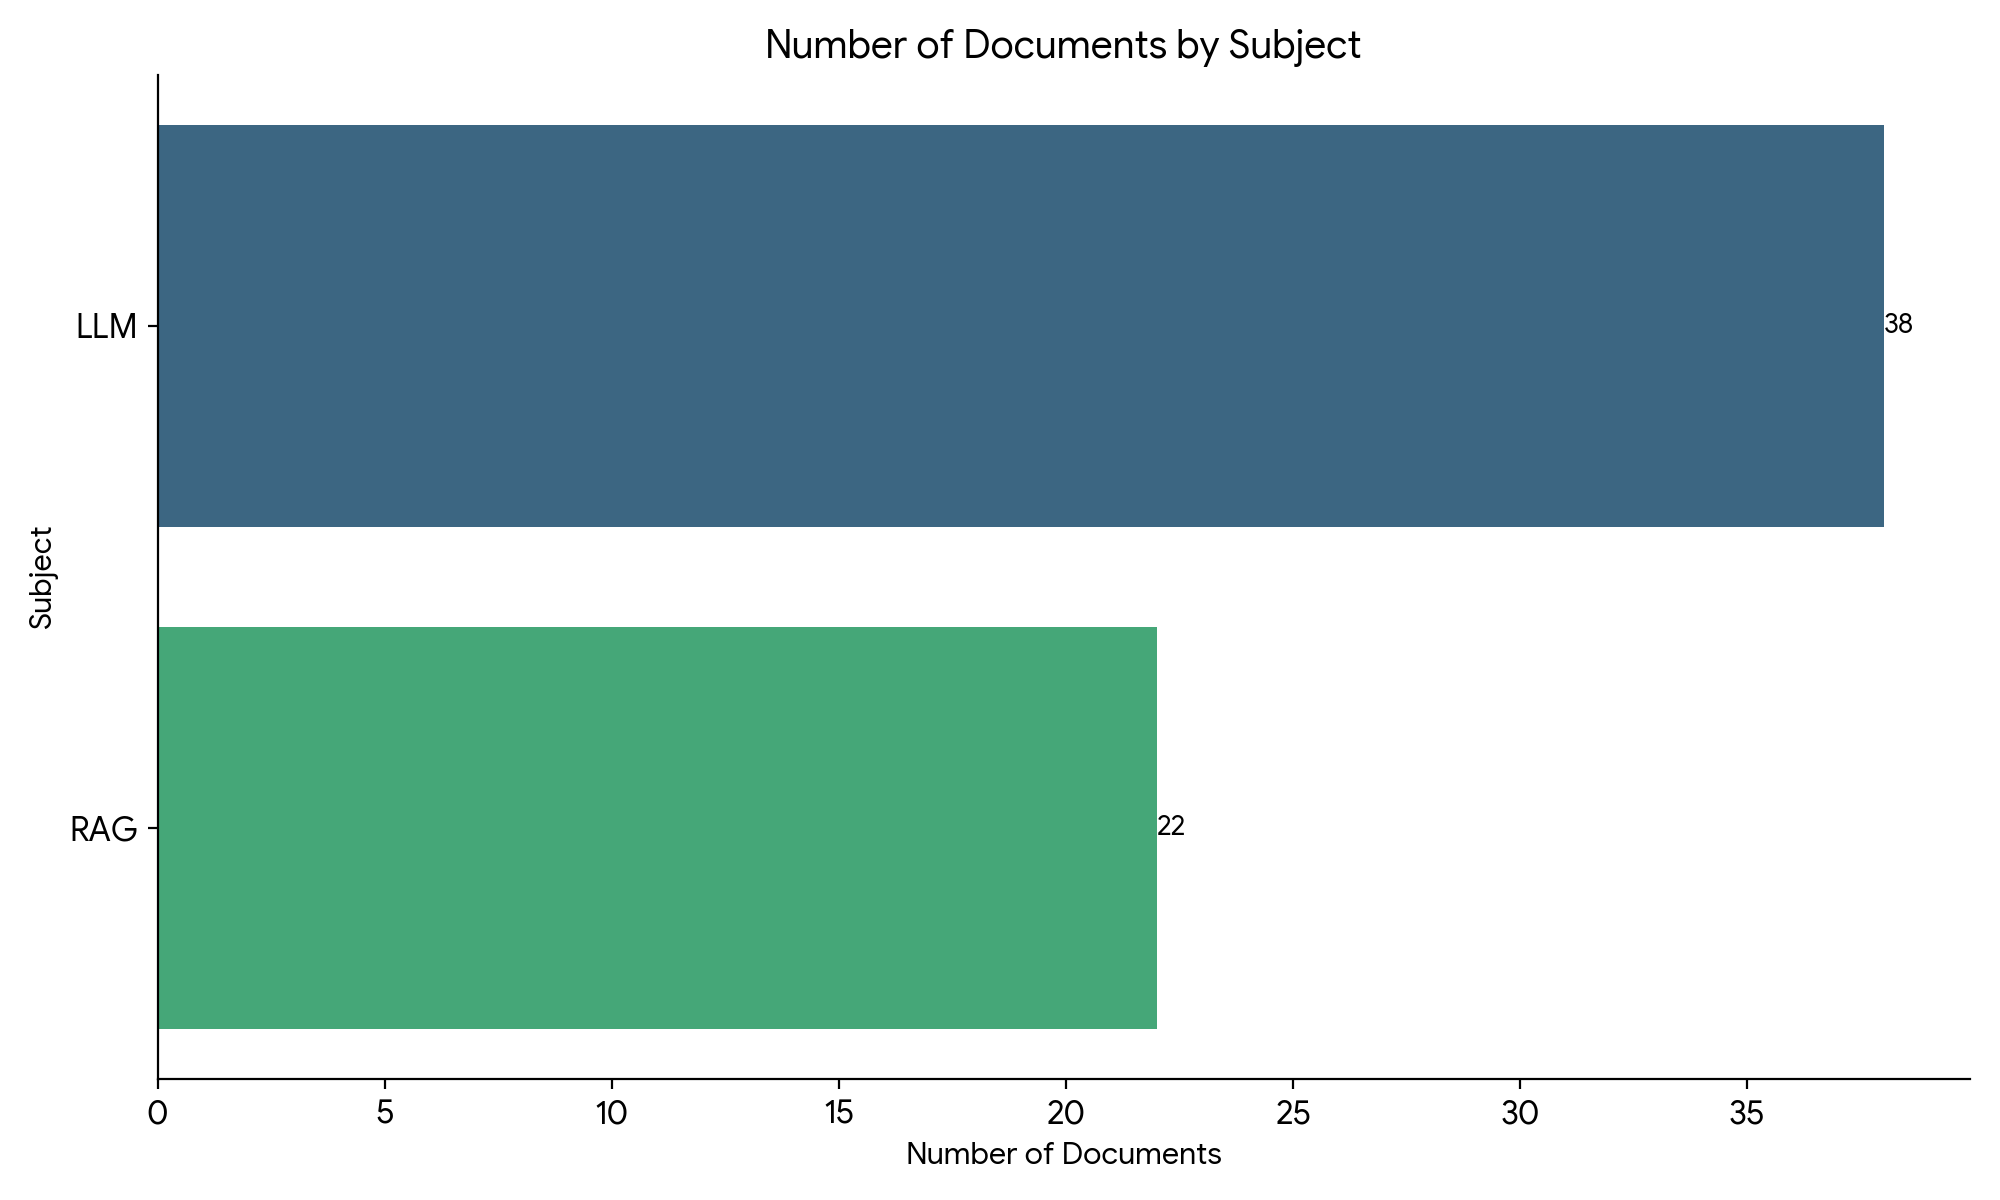

In [50]:
if OK:
    async with live_client.aio.live.connect(model=model, config=config) as session:

        message = """How many documents by subject? 
        Generate and run some code to plot this as a python seaborn chart.
        I suggest an horizontal bar chart, with the numbers inside each bar.
        """
        print(f"> {message}\n")
        await session.send(input=message, end_of_turn=True)
        await handle_response(session)

### **💬 What is the file size distribution? Generate and run some code to plot this as a python seaborn chart. I suggest a box plot, one by subject. The size is in kilo bytes, for more readability you should convert it in mega.**

> What is the file size distribution? 
        Generate and run some code to plot this as a python seaborn chart.
        I suggest a box plot, one by subject. The size is in kilo bytes, for more
        readability you should convert it in mega.
        



### Text

I can help with that! First I need to know which table contains the file size information.



### Code
```
print(default_api.list_tables())

```

### Tool call

 - DB CALL: list_tables()


### Result: Outcome.OUTCOME_OK
```
("{'result': ['files_details: this table contains informations about the files "
 'or documents stored in the database (name, subject, size, number of tokens, '
 "....']}\n")
```

### Text

Okay, the table `files_details` seems to contain the file size information. Let's examine the schema of this table to confirm the column names.



### Code
```
print(default_api.describe_table(table_name='files_details'))

```

### Tool call

 - DB CALL: describe_table(files_details)


### Result: Outcome.OUTCOME_OK
```
("{'result': [['file_id', 'TEXT', 'unique identifiant for each row in the "
 "table'], ['file_path', 'TEXT', 'the relative path to the document'], "
 "['file_size_kb', 'INTEGER', 'size of the document file in kilo bytes'], "
 "['document_subject', 'TEXT', 'main subject type of the document'], "
 "['file_name', 'TEXT', 'name of the document file'], ['title', 'TEXT', 'a "
 "title for the document'], ['tokens_number', 'INTEGER', 'number of tokens for "
 "the text in the document'], ['last_update_date', 'DATE', 'last date of "
 "document file update']]}\n")
```

### Text

Great! The `files_details` table has a `file_size_kb` column (in kilobytes) and a `document_subject` column, which is exactly what I need.

Now, let's retrieve the `file_size_kb` and `document_subject` from the `files_details` table, convert `file_size_kb` to megabytes, and generate the box plot.



### Code
```
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

query = "SELECT document_subject, file_size_kb FROM files_details"
data = default_api.execute_query(sql=query)

if data and data['result']:
    df = pd.DataFrame(data['result'], columns=['document_subject', 'file_size_kb'])
    df['file_size_mb'] = df['file_size_kb'] / 1024  # Convert KB to MB

    plt.figure(figsize=(10, 6))  # Adjust figure size for better readability
    sns.boxplot(x='document_subject', y='file_size_mb', data=df)
    plt.title('File Size Distribution by Subject')
    plt.xlabel('Subject')
    plt.ylabel('File Size (MB)')
    plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()
else:
    print("No data retrieved from the database.")

```

### Tool call

 - DB CALL: execute_query(SELECT document_subject, file_size_kb FROM files_details)


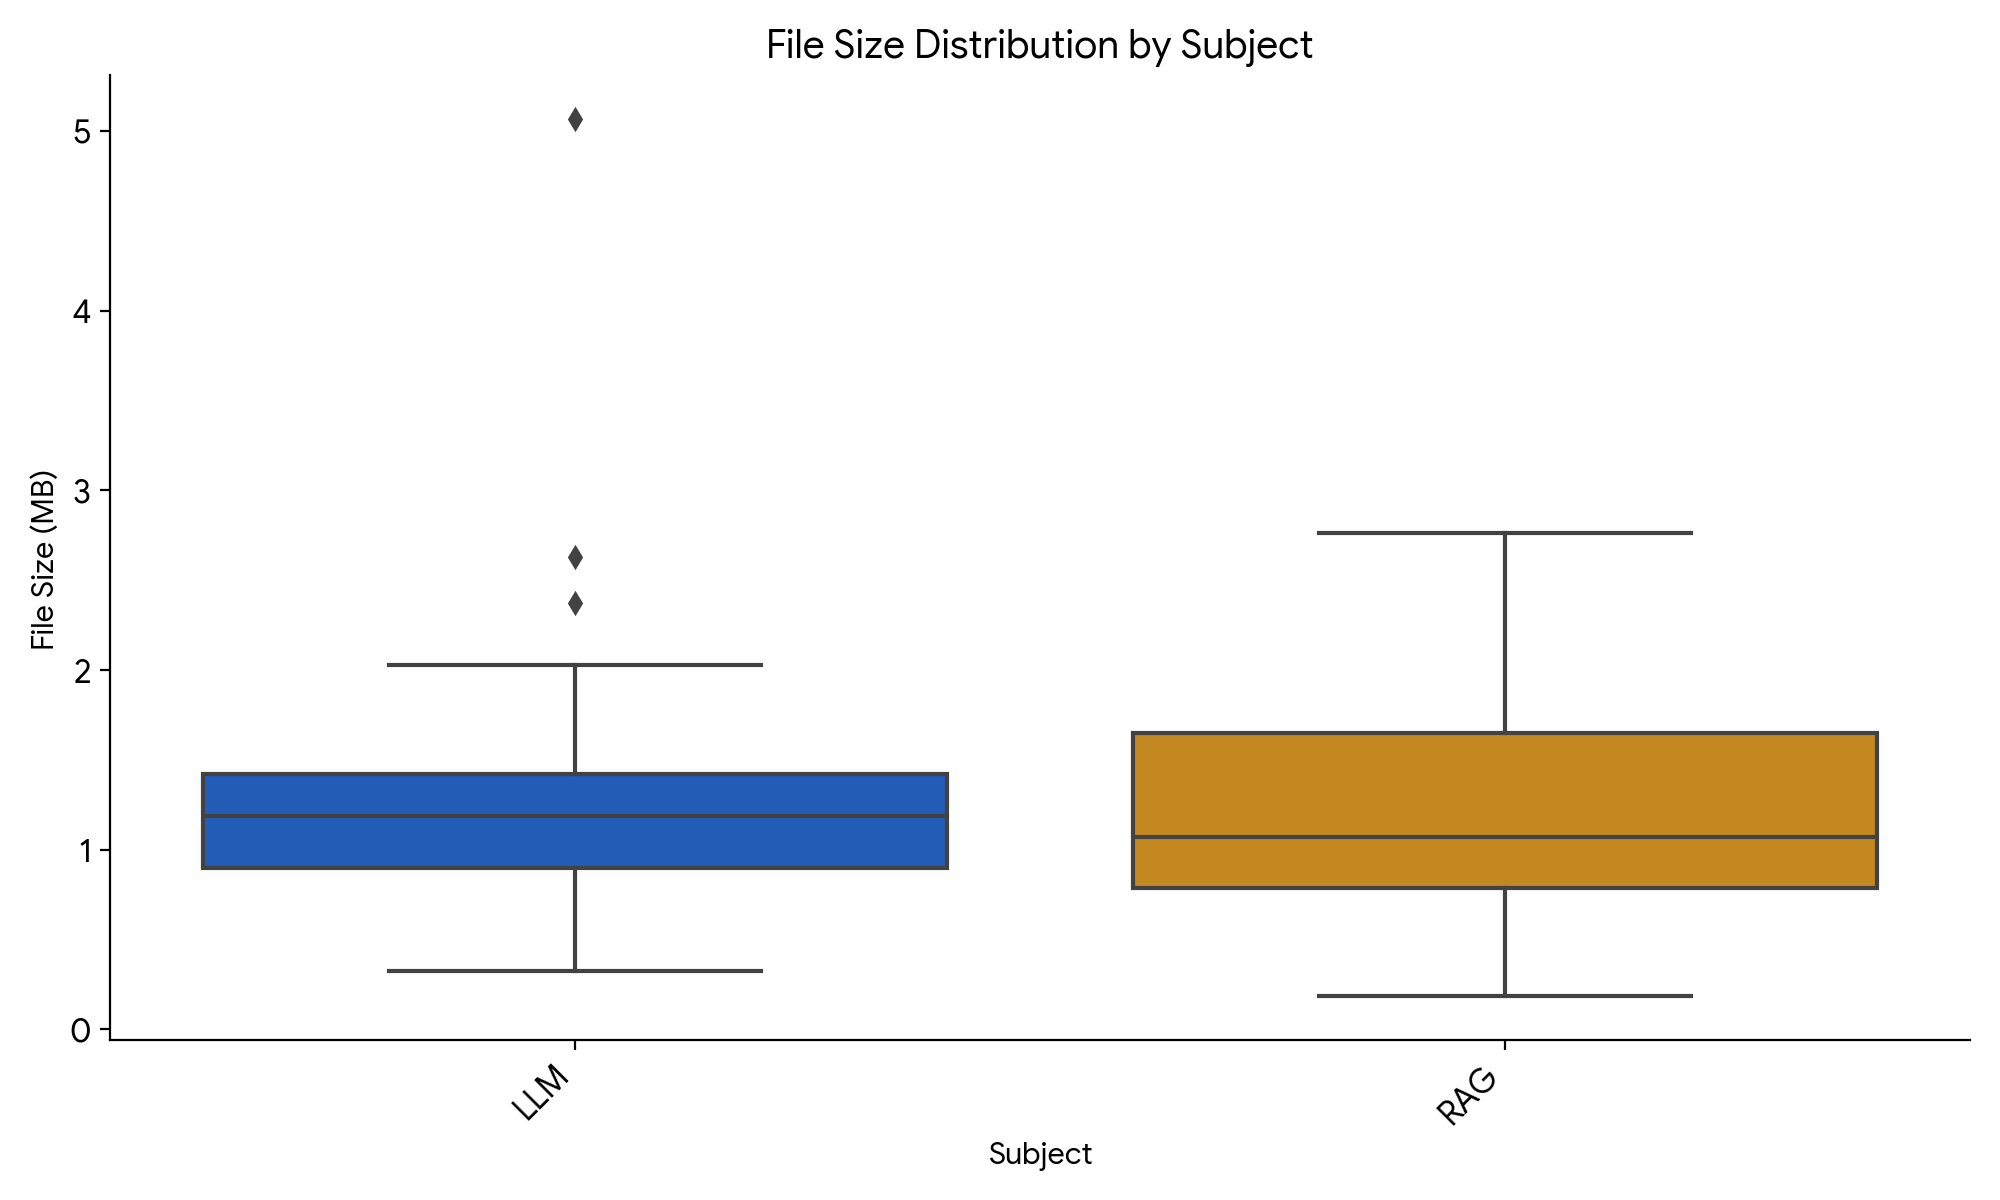

### Text

The box plot visualizes the distribution of file sizes (in MB) for each subject (LLM and RAG). From the plot, we can observe the median, quartiles, and outliers for file sizes within each subject. For example, we can see that the LLM subject has a larger outlier around 5MB.



In [22]:
if OK:
    async with live_client.aio.live.connect(model=model, config=config) as session:

        message = """What is the file size distribution? 
        Generate and run some code to plot this as a python seaborn chart.
        I suggest a box plot, one by subject. The size is in kilo bytes, for more
        readability you should convert it in mega.
        """
        print(f"> {message}\n")
        await session.send(input=message, end_of_turn=True)
        await handle_response(session)

### **💬 What is the token numbers distribution? Generate and run some code to plot this as a python seaborn chart. I suggest a distplot, one by subject.**

> What is the token numbers distribution? 
        Generate and run some code to plot this as a python seaborn chart.
        I suggest a distplot, one by subject.
        



### Text

I need to find the table containing information about tokens and their subjects. I'll start by listing the available tables and their descriptions.


### Code
```
print(default_api.list_tables())

```

### Tool call

 - DB CALL: list_tables()


### Result: Outcome.OUTCOME_OK
```
("{'result': ['files_details: this table contains informations about the files "
 'or documents stored in the database (name, subject, size, number of tokens, '
 "....']}\n")
```

### Text

The `files_details` table seems relevant. I'll describe it to understand its schema.


### Code
```
print(default_api.describe_table(table_name='files_details'))

```

### Tool call

 - DB CALL: describe_table(files_details)


### Result: Outcome.OUTCOME_OK
```
("{'result': [['file_id', 'TEXT', 'unique identifiant for each row in the "
 "table'], ['file_path', 'TEXT', 'the relative path to the document'], "
 "['file_size_kb', 'INTEGER', 'size of the document file in kilo bytes'], "
 "['document_subject', 'TEXT', 'main subject type of the document'], "
 "['file_name', 'TEXT', 'name of the document file'], ['title', 'TEXT', 'a "
 "title for the document'], ['tokens_number', 'INTEGER', 'number of tokens for "
 "the text in the document'], ['last_update_date', 'DATE', 'last date of "
 "document file update']]}\n")
```

### Text

The `files_details` table contains `tokens_number` and `document_subject`, which are exactly what I need. Now I'll query the table to get the data and then plot the distribution using seaborn.


### Code
```
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

query = "SELECT document_subject, tokens_number FROM files_details"
data = default_api.execute_query(sql=query)

if data and data['result']:
    df = pd.DataFrame(data['result'], columns=['document_subject', 'tokens_number'])

    # Plotting the distribution of token numbers by subject
    plt.figure(figsize=(12, 6))
    sns.displot(df, x="tokens_number", hue="document_subject", kind="kde", fill=True)
    plt.title("Distribution of Token Numbers by Subject")
    plt.xlabel("Number of Tokens")
    plt.ylabel("Density")
    plt.show()
else:
    print("No data retrieved from the database.")

```

### Tool call

 - DB CALL: execute_query(SELECT document_subject, tokens_number FROM files_details)


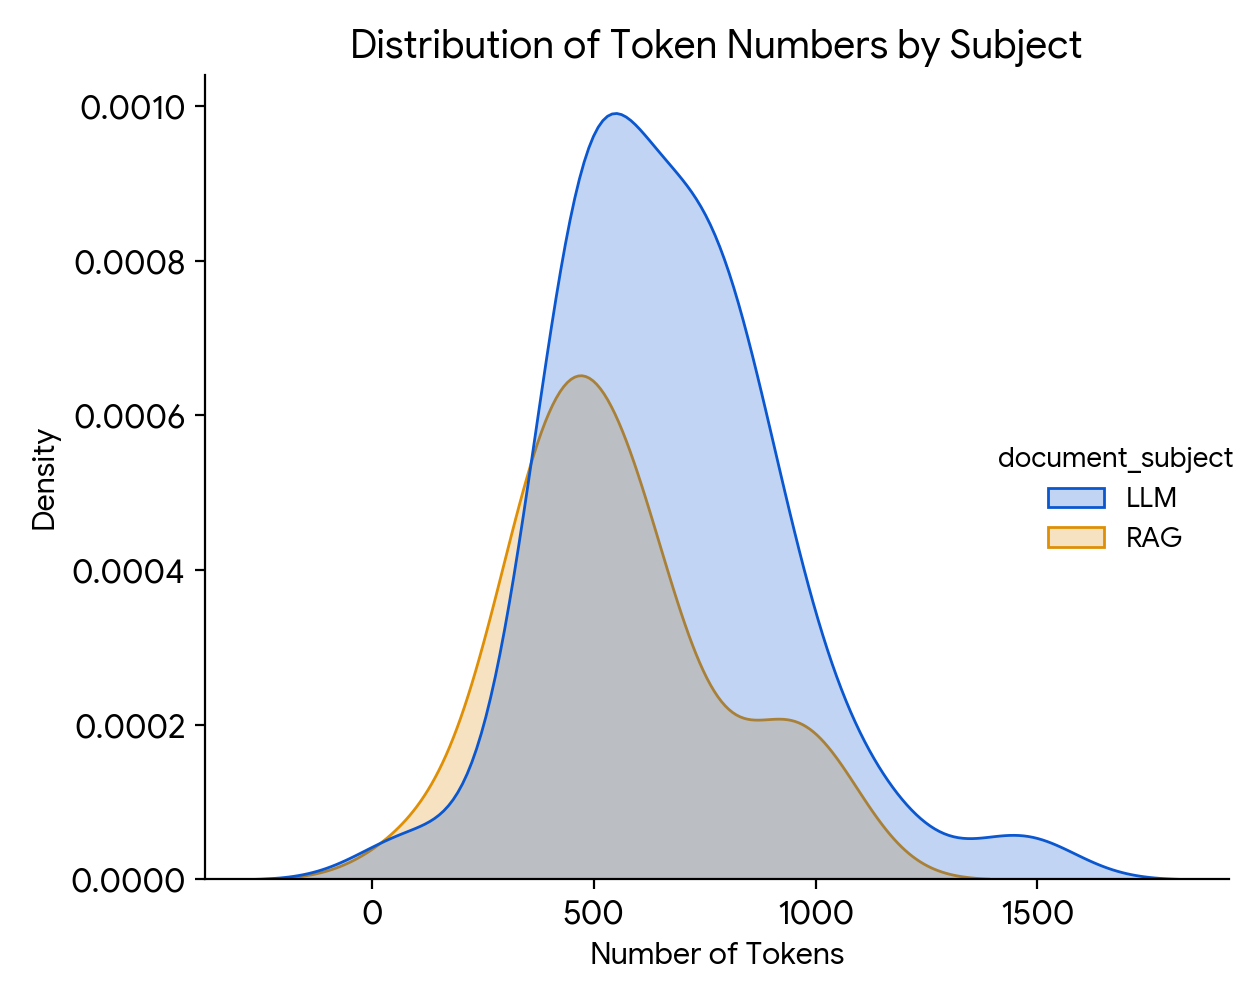

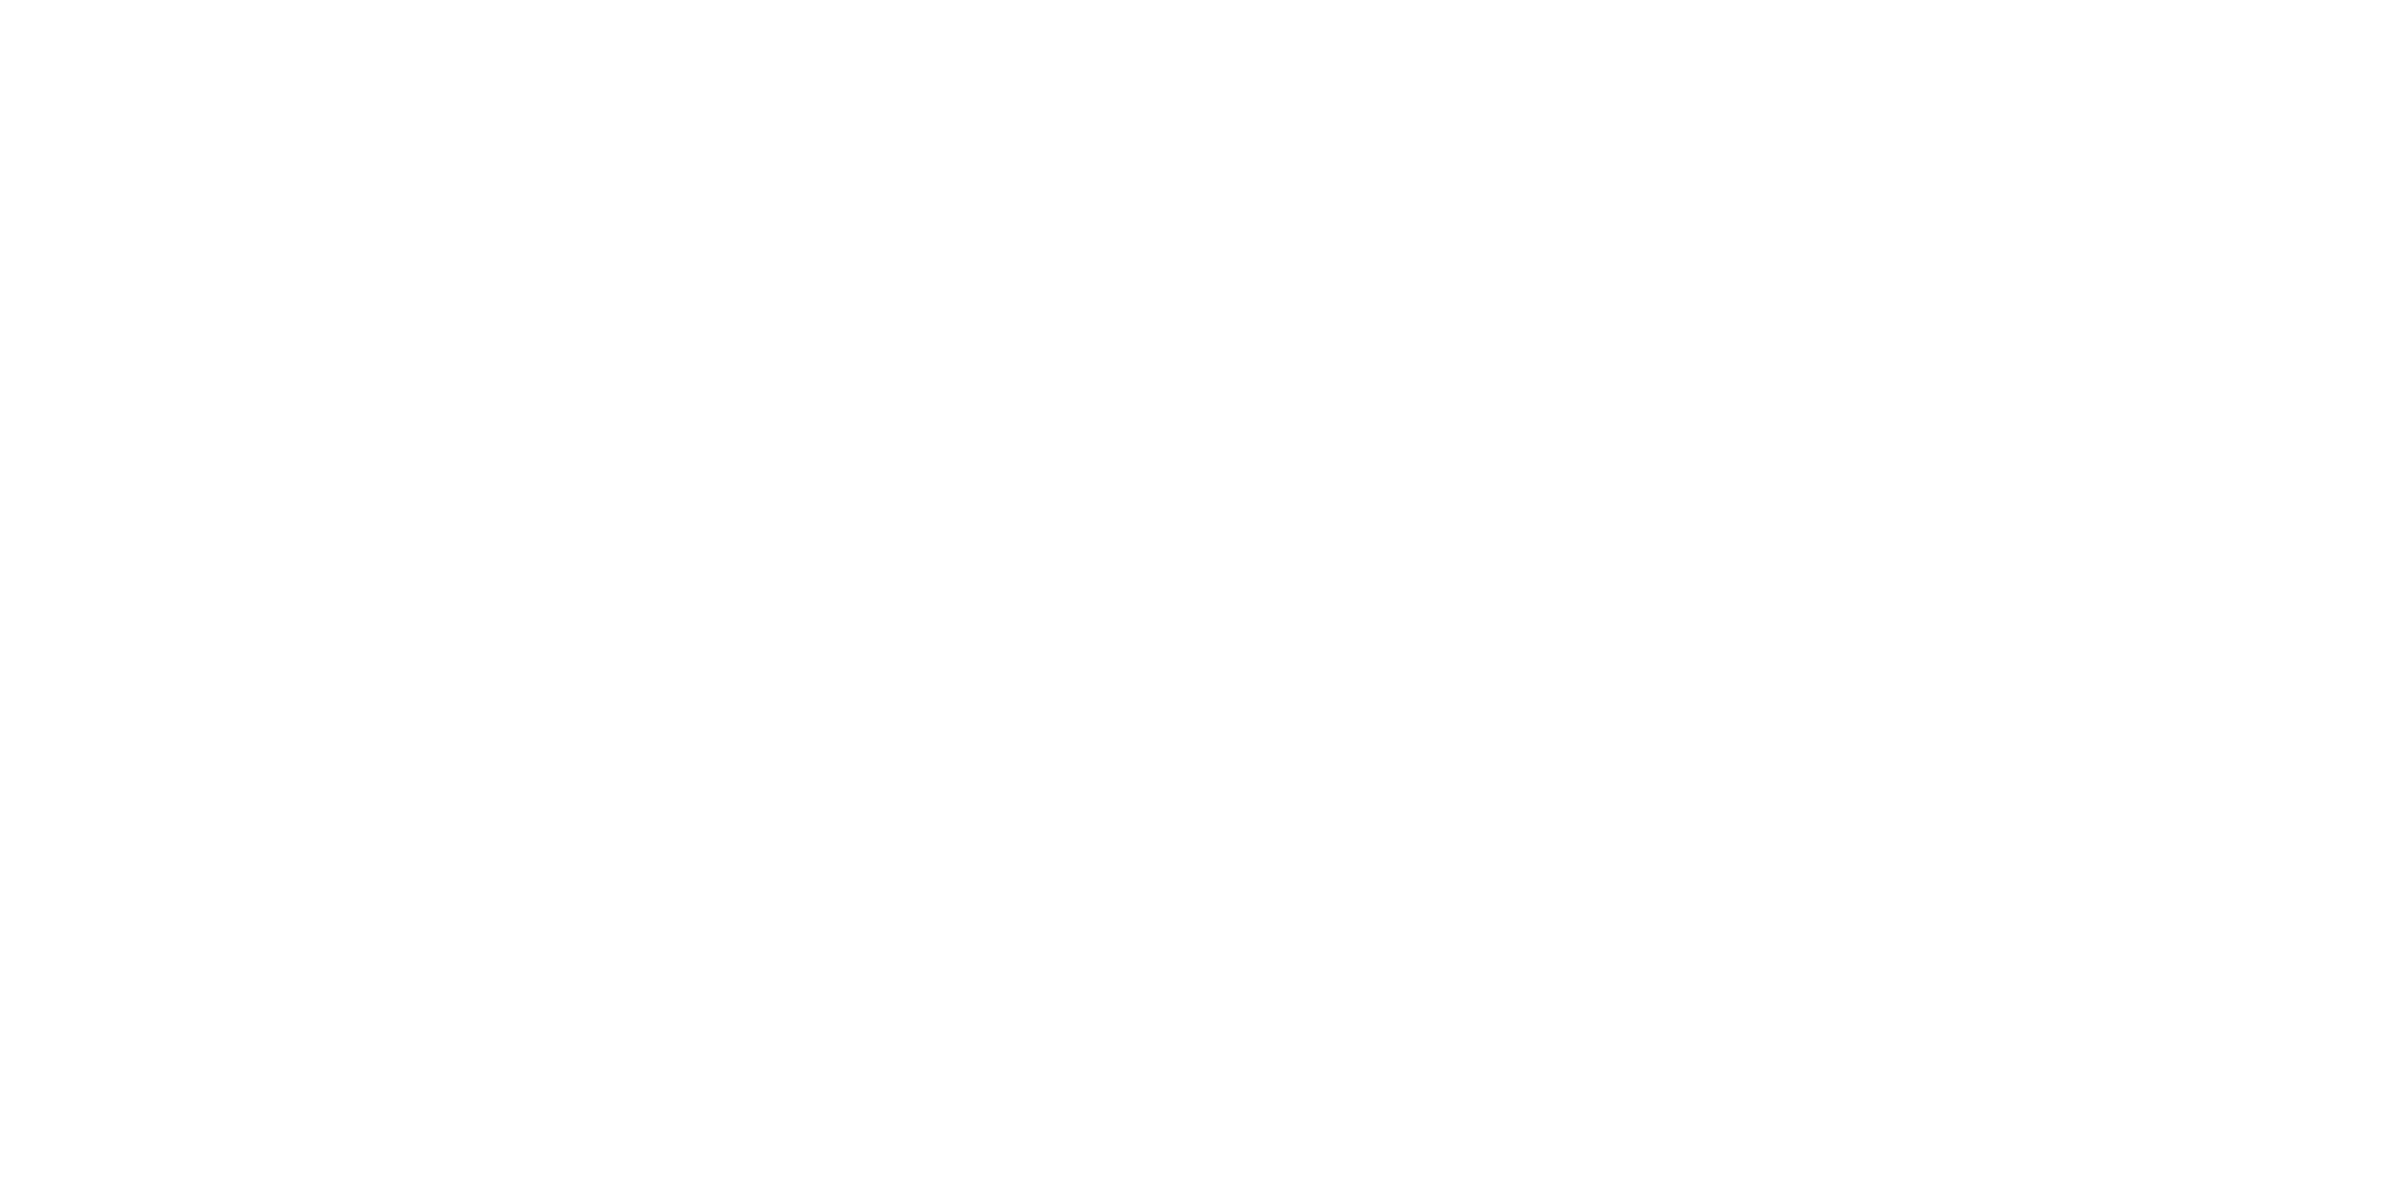

### Text

The distribution plot shows the density of token numbers for each document subject (LLM and RAG). The LLM subject seems to have a higher density of documents with token numbers around 500-700, compared to RAG.



In [23]:
if OK:
    async with live_client.aio.live.connect(model=model, config=config) as session:

        message = """What is the token numbers distribution? 
        Generate and run some code to plot this as a python seaborn chart.
        I suggest a distplot, one by subject.
        """
        print(f"> {message}\n")
        await session.send(input=message, end_of_turn=True)
        await handle_response(session)

## 💥 Nice ! We will now move on to exploring the content of the source documents.

# 🤔 How do I get answers to questions found in documents?  
### 👉 We'll use **RAG** ​​(**Retrieval **Augmented **G**eneration)  
### This feature allows you to enrich the model's answers with information from specific (custom) data.

## Initializations for search

In [24]:
if OK:
    try:
        # Custom embedding function to use with Chroma, wich implements the `EmbeddingFunction` protocol.
        class GeminiEmbeddingFunction(EmbeddingFunction):
            def __init__(self, embedding_task='retrieval_document'):
                self.embedding_task = embedding_task
            def __call__(self, input: Documents) -> Embeddings:
                # Setting task type:
                # RETRIEVAL_QUERY : Specifies the given text is a query in a search/retrieval setting.
                response = client.models.embed_content(
                                         model=EMBD_MODEL_ID,
                                         contents=input,
                                         config=types.EmbedContentConfig(
                                         task_type=self.embedding_task,
                                         ),
                )
                return [e.values for e in response.embeddings]
        ###
        client = genai.Client(api_key=GOOGLE_API_KEY)
        embed_fn = GeminiEmbeddingFunction('retrieval_query')
        persist_path = "./" + VECT_DB_NAME
        chroma_client = chromadb.PersistentClient(path=persist_path)
        db = chroma_client.get_or_create_collection(name=VECT_DB_NAME, 
                                                    embedding_function=embed_fn)

        # Max number of docs for chroma search
        CHROMA_K = dict_param["CHROMA_K"]
        # Similarity score threshold for search in chroma
        CHROMA_THRESH = dict_param["CHROMA_THRESH"]
    except Exception as e:
        print(f"ERROR during chat init: {e}")
        OK = False

## Searching for information in the documentary database

### **💬 What are the different strategies of chunking? Detail each.**

In [47]:
resp = "init"
if OK:
    query = "What are the different strategies of chunking? Detail each."
    # Search for relevant passages
    result_db = db.query(query_texts=[query], n_results=CHROMA_K)
    # Filtering on similarity score
    results = []
    for doc, meta, dist in zip(result_db['documents'][0], 
                               result_db['metadatas'][0], 
                               result_db['distances'][0]):
        if dist <= CHROMA_THRESH:
            results.append({'documents': doc, 'metadatas': meta, 'distances': dist})

    if not results:
        [all_passages] = ['No document found']
    else:
        [all_passages] = [[doc["documents"] for doc in results]]
    query_oneline = query.replace("\n", " ")
    
    prompt = f"""You are a helpful and informative bot that answers questions using text from the reference passage included below. 
    Be sure to respond in a complete sentence, being comprehensive, including all relevant background information. 
    However, you are talking to a non-technical audience, so be sure to break down complicated concepts and 
    strike a friendly and converstional tone. If the passage is irrelevant to the answer, you may ignore it.
    
    QUESTION: {query_oneline}
    """
    
    # Add the retrieved documents to the prompt.
    for passage in all_passages:
        passage_oneline = passage.replace("\n", " ")
        prompt += f"PASSAGE: {passage_oneline}\n"
    
    answer = client.models.generate_content(model=BASE_MODEL_ID,
                                            contents=prompt)

    resp = answer.text

Markdown(resp)

There are a variety of strategies for chunking, each with their own benefits and detriments. Let's take a look:

*   **Fixed-Length Chunking:** This method divides text into uniform chunks based on a predefined token or word count, making it simple to implement and ensuring consistent chunk sizes. However, it may cut off meaningful sentences and lacks adaptability to different document structures.

*   **Sentence-Based Chunking:** In this approach, text is segmented based on sentence boundaries, ensuring that each chunk contains semantically meaningful information and preserving sentence integrity. However, chunk sizes may vary significantly and may require additional processing for optimal retrieval.

*   **Overlapping (Sliding Window) Chunking:** This technique creates overlapping chunks to maintain context continuity across adjacent segments, which helps reduce the loss of key information during retrieval and is useful for handling long-form content. However, it increases storage and computation requirements and may introduce redundancy in retrieval.

*   **Topic-Based Chunking:** This strategy uses natural language understanding (NLU) techniques to group text into topic-based segments, ensuring that each chunk contains a self-contained topic and works well for knowledge-intensive tasks. However, it requires topic modeling algorithms like LDA or BERT and can be computationally expensive.

*   **Semantic Chunking:** This is an advanced text-splitting technique that focuses on dividing a document into meaningful chunks based on the actual content and context rather than arbitrary size-based methods such as token count or delimiters. The goal is to ensure that each chunk contains a single, concise meaning.

*   **Hierarchical Chunking:** This method uses multiple levels of chunking, starting with broader segments and then finer chunks within them, allowing for multi-level retrieval and optimizing information density. However, it requires more sophisticated retrieval strategies.

*   **Document-Specific Chunking:** Tailors text-splitting methods to fit different data formats such as images, PDFs, or code snippets by taking into account the unique structure and characteristics of each format to ensure meaningful segmentation.

*   **Character Text Chunking:** Divides the text into fixed-sized chunks of N characters, regardless of the content or structure.
*   **Recursive Character Text Splitting:** Recursively divides text using a predefined list of separators and intelligently merges the resulting smaller chunks into larger ones.


# 🤔 How can we orchestrate these features in a user application?  
### 👉 We'll use the **LangGraph** framework

# **Full User Interface**

## Defining functions for tools

In [26]:
@tool
def list_tables() -> list[str]:
    """Retrieve the names and descriptions of all tables in the database.
    Args:
        None
    Returns:
        type: list, 1 element give table name and description.
    """
    # Include print logging statements so you can see when functions are being called.
    print(' - DB CALL: list_tables()')

    cursor = connexion.cursor()

    # Fetch the table names.
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")

    tables = cursor.fetchall()
    result = [t[0] + ": " + DICT_DB[t[0]] for t in tables]
    return result


@tool
def describe_table(table_name: str) -> list[tuple[str, str, str]]:
    """Look up the table schema.
    Args:
        the name of the table whose schema we want.
    Returns:
      List of columns, where each entry is a tuple of (column, type, informations).
    """
    print(f' - DB CALL: describe_table({table_name})')

    cursor = connexion.cursor()

    cursor.execute(f"PRAGMA table_info({table_name});")

    schema = cursor.fetchall()
    # [column index, column name, column type, ...]
    return [(col[1], col[2], DICT_DB[col[1]]) for col in schema]

@tool
def execute_query(sql: str) -> list[tuple[str, ...]]:
    """Execute an SQL statement.
    Args:
        The SQL statement to execute.
    Returns:
        The execution result.
    """
    print(f' - DB CALL: execute_query({sql})')

    try:
        cursor = connexion.cursor()
        cursor.execute(sql)
        
        return cursor.fetchall()
    except Exception as e:
        return(f"Error during execution: {e}")


@tool
def get_document_from_file_id(file_id: str) -> str:
    """Retrieve document name from its file id.
    Args:
        The file id in the chroma database.
    Returns:
        Name of the document with this file id.
    """
    print(f' - DB CALL: get_document_from_file_id({file_id})')
    cursor = connexion.cursor()
    
    # Requête pour récupérer les champs `nom` et `ville`
    cursor.execute("""SELECT document_subject, file_name 
                        FROM files_details 
                       WHERE file_id = ?""", (file_id,))
    result = cursor.fetchone()
    
    if result:
        document_subject, file_name = result
        return file_name+" from "+document_subject+" subject."
    else:
        return "Unkown document."


@tool
def chroma_retrieve(query:str) -> str:
    """
    Retrieve documents that contains answers to the user question.
    Args:
        The user question.
    Returns:
        The passages of the documents corresponding to the query, as a list of strings.
    """
    print(f' - DB CALL: chroma_retrieve({query})')

    all_passages = ""
    # Search for relevant passages
    result_db = db.query(query_texts=[query], n_results=CHROMA_K)
    # Filtering on similarity score
    # By default, ChromaDB uses cosine distance, unless you explicitly configure it otherwise.  
    # So: distance = 1 - cos_similarity(query_vector, document_vector)    
    # (cos_similarity varies between -1 (opposite) and 1 (identical))    
    # Chroma converts this to distance: cosine_distance = 1 - cosine_similarity    
    # So: Distance = 0 → document very close (identical)    
    #     Distance close to 2 → very far (opposite)    
    # => a smaller distance means a better match.
    results = []
    for doc, meta, dist in zip(result_db['documents'][0], 
                               result_db['metadatas'][0], 
                               result_db['distances'][0]):
        if dist <= CHROMA_THRESH:
            results.append({'documents': doc, 'metadatas': meta, 'distances': dist})

    if not results:
        all_passages = 'No document found'
    else:
        all_passages = [doc["documents"] for doc in results]
    
    return ' '.join(all_passages)

## Initializations for the interface

In [27]:
if OK:
    try:
        # Chroma retrieve components
        # Custom embedding function to use with Chroma, wich implements the `EmbeddingFunction` protocol.
        class GeminiEmbeddingFunction(EmbeddingFunction):
            def __init__(self, embedding_task='retrieval_document'):
                self.embedding_task = embedding_task
            def __call__(self, input: Documents) -> Embeddings:
                # OSetting task type:
                # RETRIEVAL_QUERY : Specifies the given text is a query in a search/retrieval setting.
                response = client.models.embed_content(
                                         model=EMBD_MODEL_ID,
                                         contents=input,
                                         config=types.EmbedContentConfig(
                                         task_type=self.embedding_task,
                                         ),
                )
                return [e.values for e in response.embeddings]
        ###
        client = genai.Client(api_key=GOOGLE_API_KEY)
        connexion = sqlite3.connect(DB_NAME)
        embed_fn = GeminiEmbeddingFunction('retrieval_query')
        persist_path = "./" + VECT_DB_NAME
        chroma_client = chromadb.PersistentClient(path=persist_path)
        db = chroma_client.get_or_create_collection(name=VECT_DB_NAME, 
                                                    embedding_function=embed_fn)
        # Max number of docs for chroma search
        CHROMA_K = dict_param["CHROMA_K"]
        # Similarity score threshold for search in chroma
        CHROMA_THRESH = dict_param["CHROMA_THRESH"]
        
        # Tools
        search = DuckDuckGoSearchRun()
        tools = [list_tables, describe_table, execute_query, get_document_from_file_id, search, chroma_retrieve]
        tools_by_name = {tool.name: tool for tool in tools}
        
        # Model
        llm = ChatGoogleGenerativeAI(model=BASE_MODEL_ID, temperature=0)
        llm_with_tools = llm.bind_tools(tools)
    except Exception as e:
        print(f"ERROR during interface initialization: {e}")
        OK = False

## Creating the graph

### Components creation

In [28]:
class AgentState(TypedDict):
    """The state of the agent."""
    messages: Annotated[Sequence[BaseMessage], add_messages]
    number_of_steps: int

# Define our tool node
def call_tool(state: AgentState):
    outputs = []
    # Iterate over the tool calls in the last message
    for tool_call in state["messages"][-1].tool_calls:
        # Get the tool by name
        tool_result = tools_by_name[tool_call["name"]].invoke(tool_call["args"])
        outputs.append(
            ToolMessage(
                content=tool_result,
                name=tool_call["name"],
                tool_call_id=tool_call["id"],
            )
        )
    return {"messages": outputs}

def call_model(
    state: AgentState,
    config: RunnableConfig,):
    # Invoke the model with the system prompt and the messages
    SYSINT = (
        "system",  # 'system' indicates the message is a system instruction.
        """You are a helpful chatbot that can interact with documentary databases.
        A Sqlite database contains metadatas about the documents stored in a chroma database.
    You will take the users questions, which can be of only 2 types :
    1. descriptive analysis of the sqlite database : you will then turn them into SQL queries using the tools available. 
    Once you have the information you need, you will answer the user's question using the data returned.
    Use this tools : list_tables to see what tables are present, 
    describe_table to understand the schema, 
    and execute_query to issue an SQL SELECT query.
    The search tool give you possibilty to search on web.
    If an error occurs, you can invoke this tool to try to fix it. Remember that the database is a sqlite database, syntax may be specific.
    2. if user question is not descriptive analysis, then you must only search the response in the chroma database using the 
    chroma_retrieve tool : you absolutely can't use the search tool duckduckgo_search.
    Answers questions using passages returns by this tool. If the passage is irrelevant to the answer, you may ignore it.
    Be sure to respond in a complete sentence, being comprehensive, including all relevant background information. 
    For all responses : you are talking to a non-technical audience, so be sure to break down complicated concepts and 
    strike a friendly and converstional tone.
    You will only use the search tool duckduckgo_search if the user explicitly requests it for additional information on their last question. 
    You must not attempt to answer other questions with the search tool duckduckgo_search: if precedent chroma_retrieve tool found no documents related to the question,
    you don't use the search tool duckduckgo_search to find response.
    """
    )
    message_history = [SYSINT] + state["messages"]
    response = llm_with_tools.invoke(message_history, config)
    # We return a list, because this will get added to the existing messages state using the add_messages reducer
    return {"messages": [response]}

# Define the conditional edge that determines whether to continue or not
def should_continue(state: AgentState):
    messages = state["messages"]
    # If the last message is not a tool call, then we finish
    if not messages[-1].tool_calls:
        return "end"
    # default to continue
    return "continue"

### Creating the workflow

In [29]:
if OK:
    try:
        # Define a new graph with our state
        workflow = StateGraph(AgentState)
        
        # 1. Add our nodes 
        workflow.add_node("model", call_model)
        workflow.add_node("tools",  call_tool)
        # 2. Set the entrypoint as `model`, this is the first node called
        workflow.set_entry_point("model")
        # 3. Add a conditional edge after the `model` node is called.
        workflow.add_conditional_edges(
            # Edge is used after the `model` node is called.
            "model",
            # The function that will determine which node is called next.
            should_continue,
            # Mapping for where to go next, keys are strings from the function return, and the values are other nodes.
            # END is a special node marking that the graph is finish.
            {
                # If `tools`, then we call the tool node.
                "continue": "tools",
                # Otherwise we finish.
                "end": END,
            },
        )
        # 4. Add a normal edge after `tools` is called, `model` node is called next.
        workflow.add_edge("tools", "model")
        # Now we can compile and visualize our graph
        graph = workflow.compile()
    except Exception as e:
        print(f"ERROR during workflow creation: {e}")
        OK = False

### Workflow Visualization

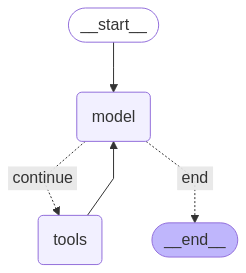

In [30]:
if OK:
    try:
        display(Image(graph.get_graph().draw_mermaid_png()))
    except:
        pass

## Dialogue with the documentary base

In [31]:
# Pause to avoid exceeding the quota limit when run all
if OK:
    time.sleep(61)

### **💬 Which tables are in the database?**

In [32]:
if OK:
    try:
        # Create our initial message dictionary
        inputs = {"messages": [("user", "Which tables are in the database?")]}
        
        # call our graph with streaming to see the steps
        for state in graph.stream(inputs, stream_mode="values"):
            last_message = state["messages"][-1]
            ok_print = True
            if isinstance(last_message, ToolMessage):
                if last_message.name == 'chroma_retrieve':
                    print("[...]")
                    ok_print = False
            if ok_print:
                last_message.pretty_print()
    except Exception as e:
        print(f"ERROR during workflow: {e}")
        OK = False

================================ Human Message =================================

Which tables are in the database?
================================== Ai Message ==================================
Tool Calls:
  list_tables (7a5e03f1-9be0-4cb0-8dca-5913300f1fc0)
 Call ID: 7a5e03f1-9be0-4cb0-8dca-5913300f1fc0
  Args:
 - DB CALL: list_tables()
================================= Tool Message =================================
Name: list_tables

['files_details: this table contains informations about the files or documents stored in the database (name, subject, size, number of tokens, ....']
================================== Ai Message ==================================

Okay, the database contains one table named `files_details`. This table stores information about the files or documents in the database, including details like the name, subject, size, and number of tokens.


### **💬 What are the different subjects?**

In [33]:
# The dialogue continues
if OK:
    try:
        state["messages"].append(("user", """What are the different subjects?"""))
        
        # call our graph with streaming to see the steps
        for state in graph.stream(state, stream_mode="values"):
            last_message = state["messages"][-1]
            ok_print = True
            if isinstance(last_message, ToolMessage):
                if last_message.name == 'chroma_retrieve':
                    print("[...]")
                    ok_print = False
            if ok_print:
                last_message.pretty_print()
    except Exception as e:
        print(f"ERROR during workflow: {e}")
        OK = False

================================ Human Message =================================

What are the different subjects ?
================================== Ai Message ==================================
Tool Calls:
  describe_table (873e29b9-a4ea-403d-8e41-1e52c023277c)
 Call ID: 873e29b9-a4ea-403d-8e41-1e52c023277c
  Args:
    table_name: files_details
 - DB CALL: describe_table(files_details)
================================= Tool Message =================================
Name: describe_table

["('file_id', 'TEXT', 'unique identifiant for each row in the table')", "('file_path', 'TEXT', 'the relative path to the document')", "('file_size_kb', 'INTEGER', 'size of the document file in kilo bytes')", "('document_subject', 'TEXT', 'main subject type of the document')", "('file_name', 'TEXT', 'name of the document file')", "('title', 'TEXT', 'a title for the document')", "('tokens_number', 'INTEGER', 'number of tokens for the text in the document')", "('last_update_date', 'DATE', 'last date of 

### **💬 About tokens number: give minimum, maximum, average, and median values for each subject.**

In [34]:
# The dialogue continues
if OK:
    try:
        state["messages"].append(("user", """About tokens number: give minimum, maximum, average, and median values for each subject."""))
        
        # call our graph with streaming to see the steps
        for state in graph.stream(state, stream_mode="values"):
            last_message = state["messages"][-1]
            ok_print = True
            if isinstance(last_message, ToolMessage):
                if last_message.name == 'chroma_retrieve':
                    print("[...]")
                    ok_print = False
            if ok_print:
                last_message.pretty_print()
    except Exception as e:
        print(f"ERROR during workflow: {e}")
        OK = False

================================ Human Message =================================

About tokens number: give minimum, maximum, average, and median values for each subject.
================================== Ai Message ==================================
Tool Calls:
  execute_query (2c081a11-8319-4953-8a89-151c4689cd3f)
 Call ID: 2c081a11-8319-4953-8a89-151c4689cd3f
  Args:
    sql: SELECT document_subject, MIN(tokens_number), MAX(tokens_number), AVG(tokens_number), MEDIAN(tokens_number) FROM files_details GROUP BY document_subject
 - DB CALL: execute_query(SELECT document_subject, MIN(tokens_number), MAX(tokens_number), AVG(tokens_number), MEDIAN(tokens_number) FROM files_details GROUP BY document_subject)
================================= Tool Message =================================
Name: execute_query

Error during execution: no such function: MEDIAN
================================== Ai Message ==================================

Ah, it seems like the SQL function `MEDIAN` is not su

### **💬 Wich file has the bigger size?**

In [35]:
# The dialogue continues
if OK:
    try:
        state["messages"].append(("user", """Wich file has the bigger size?"""))
        
        # call our graph with streaming to see the steps
        for state in graph.stream(state, stream_mode="values"):
            last_message = state["messages"][-1]
            ok_print = True
            if isinstance(last_message, ToolMessage):
                if last_message.name == 'chroma_retrieve':
                    print("[...]")
                    ok_print = False
            if ok_print:
                last_message.pretty_print()
    except Exception as e:
        print(f"ERROR during workflow: {e}")
        OK = False

================================ Human Message =================================

Wich file has the bigger size ?
================================== Ai Message ==================================
Tool Calls:
  execute_query (ca142fd1-06e0-4bc3-b50e-4d484309ad23)
 Call ID: ca142fd1-06e0-4bc3-b50e-4d484309ad23
  Args:
    sql: SELECT file_name FROM files_details ORDER BY file_size_kb DESC LIMIT 1
 - DB CALL: execute_query(SELECT file_name FROM files_details ORDER BY file_size_kb DESC LIMIT 1)
================================= Tool Message =================================
Name: execute_query

["('Day_13_Semantic_Search_Index.pdf',)"]
================================== Ai Message ==================================

The file with the largest size is 'Day\_13\_Semantic\_Search\_Index.pdf'.


### **💬 What is its subject?**

In [36]:
# The dialogue continues
if OK:
    try:
        state["messages"].append(("user", """What is its subject?"""))
        
        # call our graph with streaming to see the steps
        for state in graph.stream(state, stream_mode="values"):
            last_message = state["messages"][-1]
            ok_print = True
            if isinstance(last_message, ToolMessage):
                if last_message.name == 'chroma_retrieve':
                    print("[...]")
                    ok_print = False
            if ok_print:
                last_message.pretty_print()
    except Exception as e:
        print(f"ERROR during workflow: {e}")
        OK = False

================================ Human Message =================================

What is its subject?
================================== Ai Message ==================================
Tool Calls:
  execute_query (c39238b8-7585-4ef0-9d3d-88ba26ab3733)
 Call ID: c39238b8-7585-4ef0-9d3d-88ba26ab3733
  Args:
    sql: SELECT document_subject FROM files_details WHERE file_name = 'Day_13_Semantic_Search_Index.pdf'
 - DB CALL: execute_query(SELECT document_subject FROM files_details WHERE file_name = 'Day_13_Semantic_Search_Index.pdf')
================================= Tool Message =================================
Name: execute_query

["('LLM',)"]
================================== Ai Message ==================================

The subject of the file 'Day\_13\_Semantic\_Search\_Index.pdf' is LLM (Large Language Models).


In [37]:
# Pause to avoid exceeding the quota limit when run all
if OK:
    time.sleep(61)

### **💬 What is RAG?**

In [38]:
# The dialogue continues
if OK:
    try:
        state["messages"].append(("user", """What is RAG?"""))
        
        # call our graph with streaming to see the steps
        for state in graph.stream(state, stream_mode="values"):
            last_message = state["messages"][-1]
            ok_print = True
            if isinstance(last_message, ToolMessage):
                if last_message.name == 'chroma_retrieve':
                    print("[...]")
                    ok_print = False
            if ok_print:
                last_message.pretty_print()
    except Exception as e:
        print(f"ERROR during workflow: {e}")
        OK = False

================================ Human Message =================================

What is RAG?
================================== Ai Message ==================================
Tool Calls:
  chroma_retrieve (79bc7140-7c8c-4a7c-ad21-c37a6729ef8a)
 Call ID: 79bc7140-7c8c-4a7c-ad21-c37a6729ef8a
  Args:
    query: What is RAG?
 - DB CALL: chroma_retrieve(What is RAG?)
[...]
================================== Ai Message ==================================

Retrieval-Augmented Generation (RAG) is a hybrid AI framework that enhances the capabilities of large language models (LLMs) by integrating information retrieval with generative text generation. This approach enables models to generate more accurate, informed, and up-to-date responses by fetching relevant external data during inference. In essence, it combines a retrieval mechanism to find relevant information from a large database of documents with a generative model that uses this information to produce a coherent and contextually appropr

### **💬 Search on web if there are other thinks to say**

In [39]:
# The dialogue continues
if OK:
    try:
        state["messages"].append(("user", """Search on web if there are other thinks to say"""))
        
        # call our graph with streaming to see the steps
        for state in graph.stream(state, stream_mode="values"):
            last_message = state["messages"][-1]
            ok_print = True
            if isinstance(last_message, ToolMessage):
                if last_message.name == 'chroma_retrieve':
                    print("[...]")
                    ok_print = False
            if ok_print:
                last_message.pretty_print()
    except Exception as e:
        print(f"ERROR during workflow: {e}")
        OK = False

================================ Human Message =================================

Search on web if there are other thinks to say
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (beeb795c-1e77-429b-88e1-7deaee9e8b3b)
 Call ID: beeb795c-1e77-429b-88e1-7deaee9e8b3b
  Args:
    query: Retrieval-Augmented Generation (RAG)
================================= Tool Message =================================
Name: duckduckgo_search

RAG is a hybrid model that combines retrieval and generation to enhance text quality. It accesses external data in real-time to provide relevant, accurate, and contextual responses for various tasks. Retrieval-augmented generation (RAG) is a method to enhance generative AI models with external data sources. Learn how RAG works, why it is useful, and how NVIDIA offers tools and resources for building RAG pipelines. These modela have a information retrieval component that allows the model to access up-to-da

### **💬 Search on web if there are any negative points, shortcomings, disadvantages?**

In [40]:
# The dialogue continues
if OK:
    try:
        state["messages"].append(("user", """Search on web if there are any negative points, shortcomings, disadvantages?"""))
        
        # call our graph with streaming to see the steps
        for state in graph.stream(state, stream_mode="values"):
            last_message = state["messages"][-1]
            ok_print = True
            if isinstance(last_message, ToolMessage):
                if last_message.name == 'chroma_retrieve':
                    print("[...]")
                    ok_print = False
            if ok_print:
                last_message.pretty_print()
    except Exception as e:
        print(f"ERROR during workflow: {e}")
        OK = False

================================ Human Message =================================

Search on web if there are any negative points, shortcomings, disadvantages?
================================== Ai Message ==================================
Tool Calls:
  duckduckgo_search (cb6fca7d-6359-46a0-8ec2-44d00b2c53cb)
 Call ID: cb6fca7d-6359-46a0-8ec2-44d00b2c53cb
  Args:
    query: Retrieval-Augmented Generation (RAG) shortcomings disadvantages negative points
================================= Tool Message =================================
Name: duckduckgo_search

Introduction Retrieval-Augmented Generation (RAG) is a dominant force in the NLP field, using the combinative power of large language models and external knowledge retrieval. The RAG system has both advantages and disadvantages. The generation phase in RAG systems involves using the augmented information to generate the final response. However, this phase can be affected by limitations in the earlier retrieval and augmentation phases

### **💬 Are there any documents that discuss how LangGraph works?**

In [41]:
# The dialogue continues
if OK:
    try:
        state["messages"].append(("user", """Are there any documents that discuss how LangGraph works?"""))
        
        # call our graph with streaming to see the steps
        for state in graph.stream(state, stream_mode="values"):
            last_message = state["messages"][-1]
            ok_print = True
            if isinstance(last_message, ToolMessage):
                if last_message.name == 'chroma_retrieve':
                    print("[...]")
                    ok_print = False
            if ok_print:
                last_message.pretty_print()
    except Exception as e:
        print(f"ERROR during workflow: {e}")
        OK = False

================================ Human Message =================================

Are there any documents that discuss how LangGraph works?
================================== Ai Message ==================================
Tool Calls:
  chroma_retrieve (f94f79a2-e0bc-4b02-8708-31ffac783768)
 Call ID: f94f79a2-e0bc-4b02-8708-31ffac783768
  Args:
    query: How LangGraph works?
 - DB CALL: chroma_retrieve(How LangGraph works?)
[...]
================================== Ai Message ==================================

I'm sorry, but I was unable to find any specific documents about how LangGraph works in the retrieved documents. The documents focus more on Retrieval-Augmented Generation (RAG) in general, its components, and implementation using tools like LangChain and LlamaIndex. There is no mention of LangGraph.


### ### **💬 ### **💬 **💬 What is the capital of France?**

In [42]:
# The dialogue continues
if OK:
    try:
        state["messages"].append(("user", """What is the capital of France?"""))
        
        # call our graph with streaming to see the steps
        for state in graph.stream(state, stream_mode="values"):
            last_message = state["messages"][-1]
            ok_print = True
            if isinstance(last_message, ToolMessage):
                if last_message.name == 'chroma_retrieve':
                    print("[...]")
                    ok_print = False
            if ok_print:
                last_message.pretty_print()
    except Exception as e:
        print(f"ERROR during workflow: {e}")
        OK = False

================================ Human Message =================================

What is the capital of France?
================================== Ai Message ==================================
Tool Calls:
  chroma_retrieve (74355a97-78de-4955-a22b-03674a89de9b)
 Call ID: 74355a97-78de-4955-a22b-03674a89de9b
  Args:
    query: What is the capital of France?
 - DB CALL: chroma_retrieve(What is the capital of France?)
[...]
================================== Ai Message ==================================

I am sorry, I could not find the answer to your question in the available documents.
